In [2]:
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

In [3]:
#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [4]:
company_factor = get_data("""SELECT * FROM tfb103d_project.company_factor;""",'tfb103d_project')
#取得需要的特徵
financial_ratio = company_factor[['stock_code',
                                  'data_date',
                                  'net_profit_rate', #稅後淨利率
                                  'operating_gross_rate', #營業毛利率
                                  'current_rate', #流動比率
                                  'quick_rate',  #速動比率
                                  'debt_rate',  #負債比率
                                  'receivables_turnover_rate', #應收帳款週轉率
                                  'inventory_turnover_rate',  #存貨週轉率
                                  'cash_reinvest_rate', #現金再投資比率
                                  'avg_director_rate', #董監事持股比利
                                  'avg_director_pledge_rate', #董監事質押比利
                                  'foreign_rate_bys', #外資持股比例
                                  'over1000_rate_bys', # >1000張大股東持股比率
                                  'under400_rate_bys', # <400張股東持股比率
                                  'avg_board_bys' #平均持股張數
                                 ]].copy() 
financial_ratio

,stock_code,data_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,inventory_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,2330,20183,34.22,47.39,267.15,228.10,20.00,5.89,4.26,10.75,NaN,NaN,NaN,91.75,6.10,78.30
1,2303,20183,0.50,17.57,272.49,212.30,42.96,4.97,5.44,9.42,NaN,NaN,NaN,75.94,21.69,24.60
2,2379,20183,11.68,47.02,147.00,129.15,61.78,5.70,3.16,25.06,NaN,NaN,NaN,67.06,21.31,11.68
3,6488,20183,23.97,39.03,225.91,189.70,54.58,5.15,3.79,26.28,NaN,NaN,NaN,70.40,20.03,35.75
4,5347,20183,21.54,36.03,364.67,312.48,21.48,4.38,4.61,-1.59,NaN,NaN,NaN,88.71,7.41,52.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,6756,20201,17.33,49.59,322.29,260.22,29.08,1.93,0.97,6.62,66.30,0.0,0.0,NaN,NaN,NaN
516,6515,20202,17.87,38.17,169.94,126.69,45.53,1.67,2.20,15.68,21.43,0.0,0.0,NaN,NaN,NaN
517,6756,20202,16.31,50.20,218.17,178.44,42.57,3.88,2.08,15.70,66.30,0.0,0.0,NaN,NaN,NaN
518,6515,20203,18.93,40.47,226.29,166.16,35.34,2.85,3.47,6.50,21.40,0.0,0.0,NaN,NaN,NaN


In [151]:
#缺值處理
financial_ratio_nona = financial_ratio.copy()

#以 0 填補
financial_ratio_nona['inventory_turnover_rate'].fillna(0, inplace = True)

#刪除
financial_ratio_nona = financial_ratio_nona.dropna()

indexNames = financial_ratio_nona[ financial_ratio_nona['stock_code'] == "3686" ].index
financial_ratio_nona.drop(indexNames , inplace=True)

In [152]:
financial_ratio_nona.isnull().sum()

stock_code                   0
data_date                    0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
inventory_turnover_rate      0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [153]:
df = financial_ratio_nona
df.loc[df['stock_code'] == '3686']

,stock_code,data_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,inventory_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys


In [260]:
financial_ratio_avg = financial_ratio_nona.groupby(['stock_code']).mean()
# X = financial_ratio_avg[['net_profit_rate','debt_rate','operating_gross_rate']]
X = financial_ratio_nona[['net_profit_rate','debt_rate','operating_gross_rate']]
X

,net_profit_rate,debt_rate,operating_gross_rate
42,34.51,19.74,47.64
43,-8.45,43.35,12.95
44,9.18,57.69,44.93
45,23.82,51.95,38.52
46,25.03,21.81,38.00
...,...,...,...
505,1.49,57.65,18.53
506,25.87,20.09,53.19
507,33.14,40.34,56.86
508,5.05,53.37,22.28


In [261]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [262]:
X_scaled

array([[ 1.64326871, -1.20495511,  0.69950731],
       [-1.69806068,  0.42147459, -1.04323192],
       [-0.32684008,  1.4093188 ,  0.56336366],
       ...,
       [ 1.53671328,  0.21412375,  1.16269716],
       [-0.64806192,  1.11172557, -0.57451594],
       [ 0.75271421, -0.27084301,  0.70101444]])

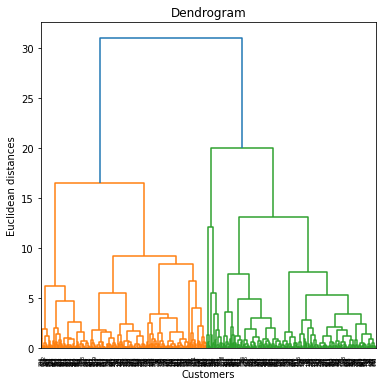

In [263]:
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

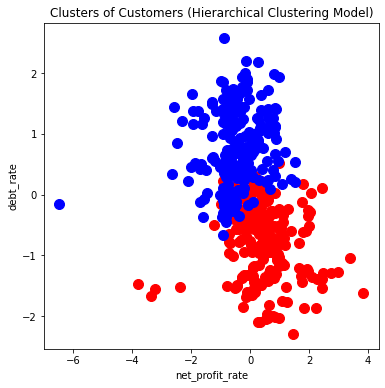

In [264]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X_scaled)
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(X_scaled[y_hc==0, 0], X_scaled[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[y_hc==1, 0], X_scaled[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
# plt.scatter(X_scaled[y_hc==2, 0], X_scaled[y_hc==2, 1], s=100, c='green', label ='Cluster 2')

plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('net_profit_rate')
plt.ylabel('debt_rate')
plt.show()


In [265]:
y_hc

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [266]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [267]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
#     random_state=42
)

In [268]:
y_kmean = kmeans.fit(X_scaled)

In [269]:
# 最少SSE(Sum of Sauare Error)誤差平方和，評量分群好壞
# The lowest SSE value
kmeans.inertia_

827.3574482623974

In [270]:
#最終質心位置
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.4691764 ,  0.69702948, -0.52288976],
       [ 0.56027862, -0.83237501,  0.62442175]])

In [271]:
#究竟做了幾次
# The number of iterations required to converge
kmeans.n_iter_

13

In [272]:
#分群結果
kmeans.labels_[:]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,

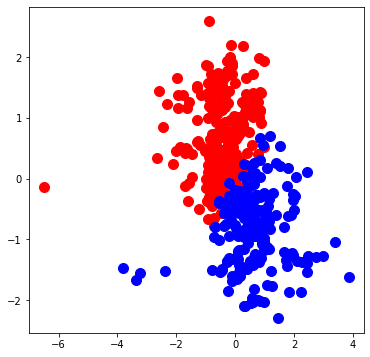

In [273]:
plt.scatter(X_scaled[kmeans.labels_==0, 0], X_scaled[kmeans.labels_==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[kmeans.labels_==1, 0], X_scaled[kmeans.labels_==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_scaled[kmeans.labels_==2, 0], X_scaled[kmeans.labels_==2, 1], s=100, c='green', label ='Cluster 2')

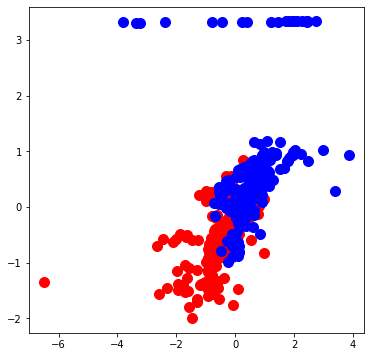

In [274]:
plt.scatter(X_scaled[kmeans.labels_==0, 0], X_scaled[kmeans.labels_==0, 2], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[kmeans.labels_==1, 0], X_scaled[kmeans.labels_==1, 2], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_scaled[kmeans.labels_==2, 0], X_scaled[kmeans.labels_==2, 2], s=100, c='green', label ='Cluster 2')

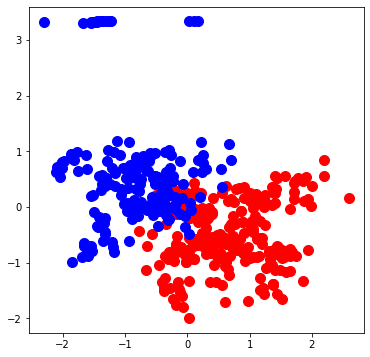

In [275]:
plt.scatter(X_scaled[kmeans.labels_==0, 1], X_scaled[kmeans.labels_==0, 2], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[kmeans.labels_==1, 1], X_scaled[kmeans.labels_==1, 2], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_scaled[kmeans.labels_==2, 1], X_scaled[kmeans.labels_==2, 2], s=100, c='green', label ='Cluster 2')

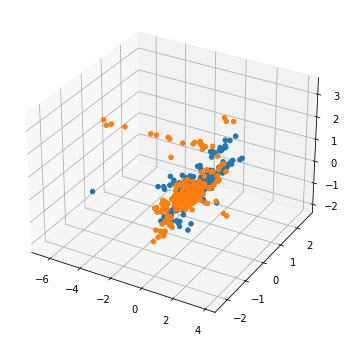

In [276]:
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled[kmeans.labels_==0, 0],X_scaled[kmeans.labels_==0, 1],X_scaled[kmeans.labels_==0, 2],alpha=1)
ax4.scatter(X_scaled[kmeans.labels_==1, 0],X_scaled[kmeans.labels_==1, 1],X_scaled[kmeans.labels_==1, 2],alpha=1)
plt.show()

In [277]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [278]:
dbscan = DBSCAN(eps=0.9)
dbscan.fit(X_scaled)

DBSCAN(eps=0.9)

In [279]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

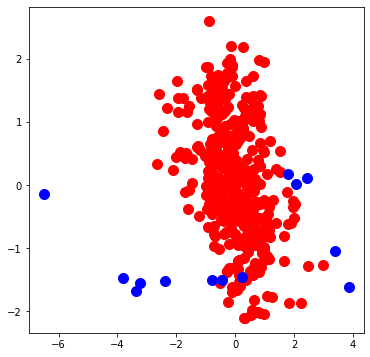

In [280]:
plt.scatter(X_scaled[dbscan.labels_==0, 0], X_scaled[dbscan.labels_==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[dbscan.labels_==-1, 0], X_scaled[dbscan.labels_==-1, 1], s=100, c='blue', label ='Cluster 2')

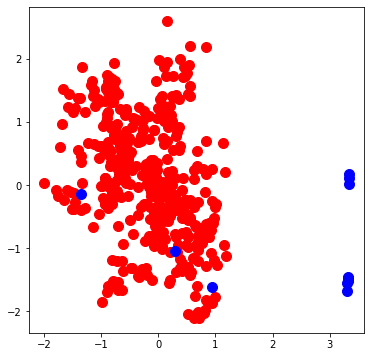

In [281]:
plt.scatter(X_scaled[dbscan.labels_==0, 2], X_scaled[dbscan.labels_==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[dbscan.labels_==-1, 2], X_scaled[dbscan.labels_==-1, 1], s=100, c='blue', label ='Cluster 2')

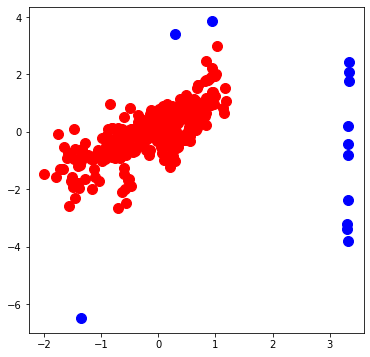

In [282]:
plt.scatter(X_scaled[dbscan.labels_==0, 2], X_scaled[dbscan.labels_==0, 0], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[dbscan.labels_==-1, 2], X_scaled[dbscan.labels_==-1, 0], s=100, c='blue', label ='Cluster 2')

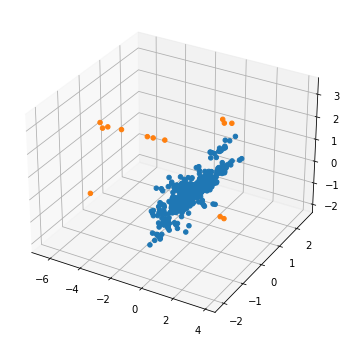

In [283]:
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled[dbscan.labels_==0, 0],X_scaled[dbscan.labels_==0, 1],X_scaled[dbscan.labels_==0, 2],alpha=1)
ax4.scatter(X_scaled[dbscan.labels_==-1, 0],X_scaled[dbscan.labels_==-1, 1],X_scaled[dbscan.labels_==-1, 2],alpha=1)
plt.show()